<a href="https://colab.research.google.com/github/citruscaesar/building-footprint-extraction/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install rasterio
%pip install lightning
%pip install segmentation-models-pytorch
%pip install torchmetrics
%pip install patchify

In [ ]:
!git clone https://github.com/citruscaesar/building-footprint-extraction.git
!cp -r ./building-footprint-extraction/src/ ./ 
!rm -r ./building-footprint-extraction

Cloning into 'building-footprint-extraction'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 18), reused 32 (delta 7), pack-reused 0
Unpacking objects: 100% (49/49), 5.37 MiB | 8.23 MiB/s, done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
from pathlib import Path
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from patchify import patchify, unpatchify
from src.lightningmodule import SegmentationModule

from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

In [ ]:
INRIA = Path.cwd() / "drive" / "MyDrive"/ "datasets" / "inria" / "AerialImageDataset"
SCENES = INRIA / "train" / "images"
MASKS = INRIA / "train" / "gt"
CHECKPOINTS = INRIA.parent / "checkpoints"

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Load Model

In [ ]:
checkpoint_path = next(CHECKPOINTS.iterdir())
checkpoint = torch.load(checkpoint_path)
unet = smp.Unet("resnet18") 
preprocess = get_preprocessing_fn("resnet18")
model = SegmentationModule(unet,
                           loss = "dice",
                           learning_rate = 3e-4,
                           batch_size = 4)
model.load_state_dict(checkpoint["state_dict"])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


<All keys matched successfully>

In [ ]:
def load_raster(raster_path):
    with rio.open(raster_path) as raster:
        return raster.read()

### Idea 1: Inference on Entire Scene

In [ ]:
%mkdir -p ./inria/train/images
%mkdir -p ./inria/train/gt
!cp ./drive/MyDrive/

In [ ]:
import shutil

loc = "austin1.tif"
scene_path = SCENES / loc
mask_path = MASKS / loc 

dest_scene_path = Path.cwd() / "inria" / "train" / "images" / loc
dest_mask_path = Path.cwd() / "inria" / "train" / "gt" / loc

shutil.copy(scene_path, dest_scene_path)
shutil.copy(mask_path, dest_mask_path)

PosixPath('/content/inria/train/gt/austin1.tif')

In [101]:
scene = torch.from_numpy(load_raster(dest_scene_path)).to(torch.float)
mask = torch.from_numpy(load_raster(dest_mask_path)).to(torch.float)

In [102]:
size = ((5000//32) + 1) * 32
#size = 2048 
scale_up = transforms.Resize(size = (size, size))
scale_down = transforms.Resize(size = (5000, 5000))

In [103]:
scene /= 255.
scene = scale_up(scene)
scene = scene.unsqueeze(dim = 0).to(DEVICE)

mask = mask.clip(0, 1).float()

In [104]:
print(scene.shape)
print(scene.device)

torch.Size([1, 3, 5024, 5024])
cuda:0


In [105]:
model = model.to(DEVICE)
print(model.device)

cuda:0


In [107]:
model.eval()
with torch.no_grad():
    pred_mask = model.forward(scene)
    pred_mask = scale_down(pred_mask)
    mask = mask.to(DEVICE)
    dice = BinaryF1Score().to(DEVICE)
    print(dice(pred_mask[0], mask))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(0.8789, device='cuda:0')


(-0.5, 5023.5, 5023.5, -0.5)

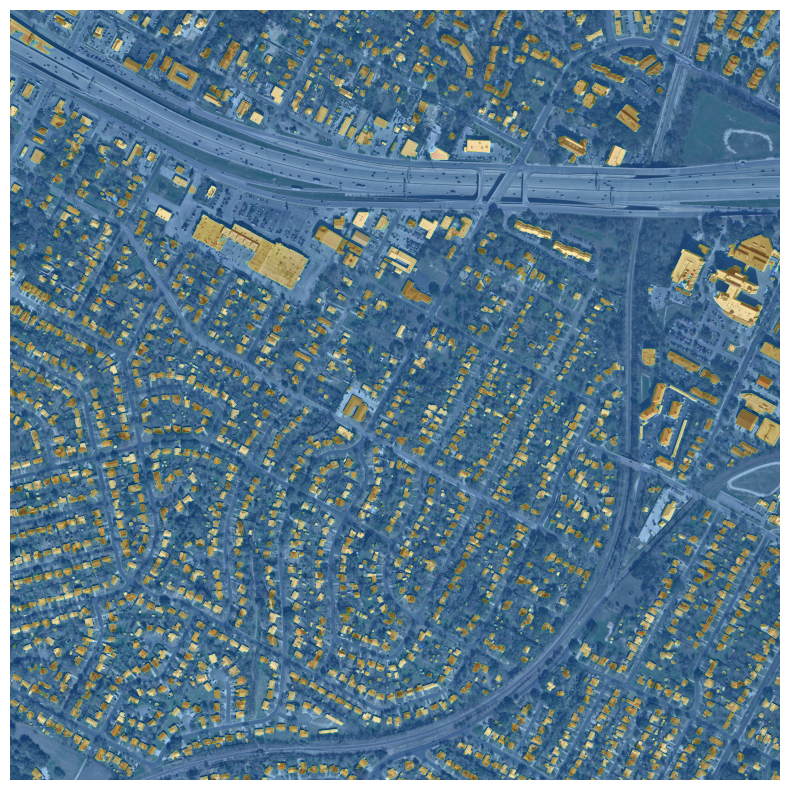

In [85]:
plt.figure(figsize = (10,10))
plt.imshow(scene[0].permute(1, 2, 0).cpu())
plt.imshow(pred_mask[0].permute(1, 2, 0).cpu(), cmap = 'jet', alpha = .3)
plt.axis("off")

### Idea 2: Inference on Non-Overlapping Patches

In [ ]:
raster_path = next(DATA.iterdir())
with rio.open(raster_path) as raster:
    scene = raster.read()

(-0.5, 4999.5, 4999.5, -0.5)

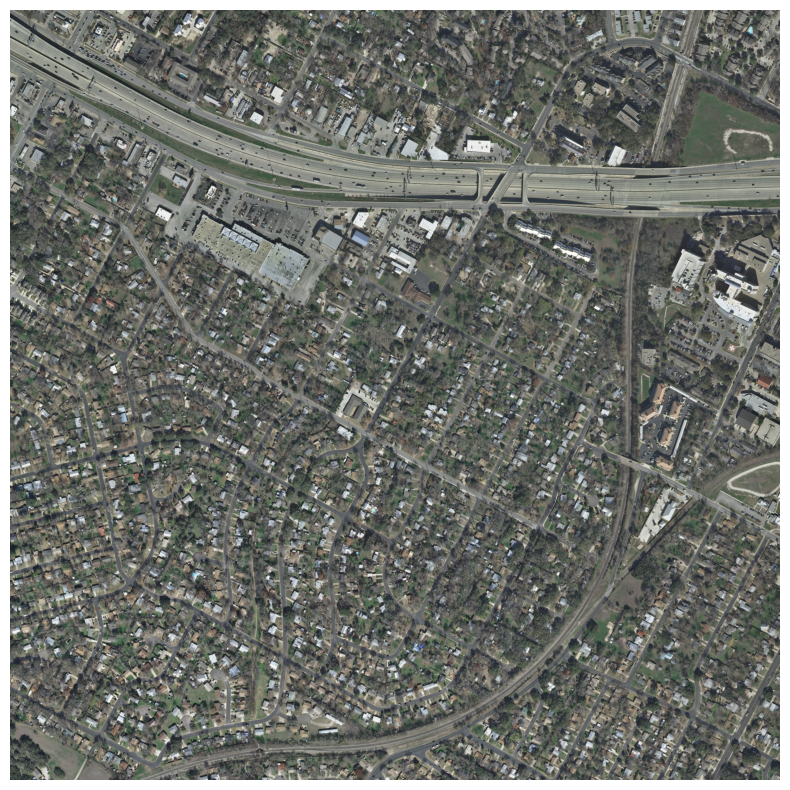

In [ ]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(scene.transpose(1, 2, 0))
plt.axis("off")

In [ ]:
patches = patchify(scene.transpose(1, 2, 0), (512, 512, 3), step = 408)

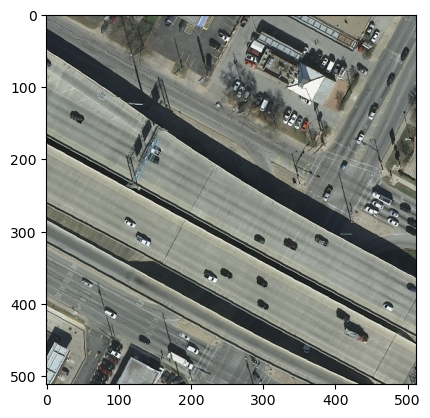

In [ ]:
plt.imshow(patches.squeeze()[0, 0])

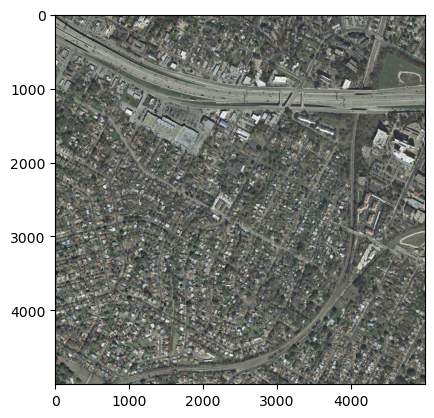

In [ ]:
plt.imshow(unpatchify(patches, imsize = (5000, 5000, 3)))


In [ ]:
BINARY_LOSS = "binary"
MULTICLASS_LOSS = "multiclass"

In [ ]:
"binary" in {BINARY_LOSS, MULTICLASS_LOSS}

True